In [20]:
#Export
import random
import torch
import torchaudio
import os
import numpy as np
import matplotlib.pyplot as plt
os.system("python notebook2script.py SparseImageWarp.ipynb")
from exp.nb_SparseImageWarp import sparse_image_warp
from torchaudio import transforms
from python_speech_features import logfbank, fbank
from collections import namedtuple

Traceback (most recent call last):
  File "notebook2script.py", line 3, in <module>
    import json,fire,re
ModuleNotFoundError: No module named 'fire'


In [21]:
# 这个作者给的特征提取的代码
class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip. This method is sourced from an earlier release of torchaudio and
    is no longer present in current versions.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db

# audio是第一个参数，需要用IPYthon来读取这个音频
def tfm_spectro(ad, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sample_rate=ad.sr, n_mels=n_mels, n_fft=n_fft, win_length=ws, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    if to_db_scale: mel = SpectrogramToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

In [22]:
# 把张量打印出来
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,1)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

In [23]:
#Export
def time_warp(spec, W=50):
    num_rows = spec.shape[2]
    spec_len = spec.shape[1]
    device = spec.device

    # adapted from https://github.com/DemisEom/SpecAugment/
    pt = (num_rows - 2* W) * torch.rand([1], dtype=torch.float) + W # random point along the time axis
    src_ctr_pt_freq = torch.arange(0, spec_len // 2)  # control points on freq-axis
    src_ctr_pt_time = torch.ones_like(src_ctr_pt_freq) * pt  # control points on time-axis
    src_ctr_pts = torch.stack((src_ctr_pt_freq, src_ctr_pt_time), dim=-1)
    src_ctr_pts = src_ctr_pts.float().to(device)

    # Destination
    w = 2 * W * torch.rand([1], dtype=torch.float) - W# distance
    dest_ctr_pt_freq = src_ctr_pt_freq
    dest_ctr_pt_time = src_ctr_pt_time + w
    dest_ctr_pts = torch.stack((dest_ctr_pt_freq, dest_ctr_pt_time), dim=-1)
    dest_ctr_pts = dest_ctr_pts.float().to(device)

    # warp
    source_control_point_locations = torch.unsqueeze(src_ctr_pts, 0)  # (1, v//2, 2)
    dest_control_point_locations = torch.unsqueeze(dest_ctr_pts, 0)  # (1, v//2, 2)
    warped_spectro, dense_flows = sparse_image_warp(spec, source_control_point_locations, dest_control_point_locations)
    return warped_spectro.squeeze(3)

def test_time_warp():
    tensor_to_img(time_warp(spectro))

In [24]:
def freq_mask(spec, F=70, num_masks=2, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))

In [25]:
#Export
def time_mask(spec, T=40, num_masks=2, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))

<class 'numpy.ndarray'>


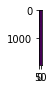

(1, 1990, 80)

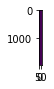

torch.Size([1, 1990, 80])

In [28]:
# 接入到conformer里面来
import scipy.io.wavfile as wav
(rate, signal) = wav.read('/root/autodl-tmp/HLT/SpecAugment/party-crowd.wav')
fbank_feats,_= fbank(signal, rate, nfilt=80, winlen=0.005, winstep=0.005)
fbank_feats = np.array(torch.unsqueeze(torch.tensor(fbank_feats), 0))
print(type(fbank_feats))
combined = time_mask(freq_mask(time_warp(torch.tensor(fbank_feats)), num_masks=2), num_masks=2)
tensor_to_img(fbank_feats)
tensor_to_img(combined)
